In [92]:
# Referencia:
#
# vector de variables w:
#  w(1)=u1
#  w(2)=x1
#  w(3)=v1
#  w(4)=y1
#  w(5)=u2
#  w(6)=x2
#  w(7)=v2
#  w(8)=y2
#
# relación entre variables
#  dx1/dt=u1
#  dy1/dt=v1
#  dx2/dt=u2
#  dy2/dt=v2

# Descripción: Funcion que devuelve la derivada de las variables del problema de dos cuerpos bajo atracción gravitatoria.
# entrada: w  | (float array) Variables del problema en el paso de tiempo.
# entrada: G  | (float) Constante universal gravitatoria.
# entrada: M1 | (float) Masa cuerpo 1.
# entrada: M2 | (float) Masa cuerpo 2.
# salida:  dw | (float array) Array con la derivada temporal de las variables del problema en el paso de tiempo.
function [dw]=ecuacion_de_movimiento(w,G,M1,M2)
    a = ((w(6)-w(2))**2+(w(8)-w(4))**2)^(3/2);
    k1 = G*M2/a;
    k2 = G*M1/a;
    dw(1) = k1*(w(6)-w(2));
    dw(2) = w(1);
    dw(3) = k1*(w(8)-w(4));
    dw(4) = w(3);
    dw(5) = k2*(w(2)-w(6));
    dw(6) = w(5);
    dw(7) = k2*(w(4)-w(8));
    dw(8) = w(7);
endfunction

# descripcion: Grafica la órbita de las dos particulas.
# entrada: solution | (float array) Solución numérica obtenida con el solver.
function plot_orbits(solution)
    plot(solution(:,2),solution(:,4));
    hold on;
    plot(solution(:,6),solution(:,8));
end

# descripcion: Resuelve una EDO del movimiento de dos particulas bajo campo gravitatorio con el metodo theta.
# entrada: w0          | (float array) Condiciones iniciales.
# entrada: h           | (float) Paso de tiempo.
# entrada: tf          | (float) Tiempo final (se asume tiempo incial igual a 0).
# entrada: G           | (float) Constante universal gravitatoria.
# entrada: M1          | (float) Masa cuerpo 1.
# entrada: M2          | (float) Masa cuerpo 2.
# entrada: theta       | (float) Valor entre 0 y 1 que determina el método numérico a utilizar.
# entrada: root_solver | (integer) 0 si utiliza método de punto fijo con la fórmula del método y 1 si se utiliza la funcion fsolve de octave.
# entrada: Tol         | (float) Toleracia de error relativo para el método de aproximaciones sucesivas.
# entrada: MaxIter     | (integer) Máximo número de iteracines del método de aproximaciones sucesivas.
# salida:  sol         | (float array) Array con la solución en cada paso de tiempo (cada fila representa el valor de las variables en un tiempo especifico).
# salida:  call        | (float) Numero de llamadas a la función que devuelve la derivada de las variables del problema.
# salida:  time        | (float) Tiempo total de cálculo para resolver el problema de EDO con valores iniciales.
function [sol,calls,time]=solver_theta(w0,N,tf,G,M1,M2,theta,root_solver,Tol,MaxIter)
    profile off;
    profile clear;
    profile on;
    h = tf/(N-1);
    w = w0;
    sol(1,:) = w0;
    tic();
    for i=2:N
        punto_anterior = w;
        derivada_punto_anterior = ecuacion_de_movimiento(punto_anterior,G,M1,M2);
        if (theta==0)
            w = punto_anterior+h*derivada_punto_anterior;
        elseif (theta==1)
            if (root_solver==0)
                iter = 0;
                err = 1;
                while (err>Tol&&iter<MaxIter)
                    w_ant = w;
                    w = punto_anterior+h*ecuacion_de_movimiento(w,G,M1,M2);
                    err = norm(w-w_ant)/norm(w_ant);
                    iter = iter+1;
                end
                if (iter==MaxIter)
                    printf("WARNING: Could not find root with specified accuracy.\nErr: %e (tol: %e)\nIterations: %d (Maxiter: %d)",err,Tol,iter,MaxIter);
                end
            elseif (root_solver==1)
                f = @(G_p,M1_p,M2_p,h_p,w_p) @(x) w_p+h_p*ecuacion_de_movimiento(x,G_p,M1_p,M2_p)-x;
                w = fsolve(f(G,M1,M2,h,punto_anterior),punto_anterior);
            else
                printf("Defina que método para buscar raices de una función se debe utilizar.\n")
                printf("Elija 0 para utilizar el método de punto fijo con la fórmula de iter-\nación del método theta o 1 si se utiliza la función fsolve de octave.")
            end
        else
            if (root_solver==0)
                iter = 0;
                err = 1;
                while (err>Tol&&iter<MaxIter)
                    w_ant = w;
                    w = punto_anterior+h*(theta*ecuacion_de_movimiento(w,G,M1,M2)+(1-theta)*derivada_punto_anterior);
                    err = norm(w-w_ant)/norm(w_ant);
                    iter = iter+1;
                end
                if (iter==MaxIter)
                    printf("WARNING: Could not find root with specified accuracy.\nErr: %e (tol: %e)\nIterations: %d (Maxiter: %d)",err,Tol,iter,MaxIter);
                end
            elseif (root_solver==1)
                f = @(G_p,M1_p,M2_p,h_p,w_p,edm) @(x) w_p+h_p*(ecuacion_de_movimiento(x,G_p,M1_p,M2_p)*theta+(1-theta)*derivada_punto_anterior)-x;
                w = fsolve(f(G,M1,M2,h,punto_anterior,derivada_punto_anterior),punto_anterior);
            else
                printf("Defina que método para buscar raices de una función se debe utilizar.\n")
                printf("Elija 0 para utilizar el método de punto fijo con la fórmula de iter-\nación del método theta o 1 si se utiliza la función fsolve de octave.")
            end
        end
        sol(i,:) = w;
    end
    time = toc();
    profile off;
    calls = get_function_calls("ecuacion_de_movimiento",profile("info"));
endfunction

# descripcion: Resuelve una EDO del movimiento de dos partículas bajo campo gravitatorio con la función lsode (metodo de integracion de Adams).
# entrada: w0    | (float array) Condiciones iniciales.
# entrada: h     | (float) Paso de tiempo.
# entrada: tf    | (float) Tiempo final (se asume tiempo incial igual a 0).
# entrada: G     | (float) Constante universal gravitatoria.
# entrada: M1    | (float) Masa cuerpo 1.
# entrada: M2    | (float) Masa cuerpo 2.
# entrada: theta | (float) Valor entre 0 y 1 que determina el método numérico a utilizar.
# salida:  sol   | (float array) Array con la solución en cada paso de tiempo (cada fila representa el valor de las variables en un tiempo especifico).
# salida:  calls | (float) Numero de llamadas a la función que devuelve la derivada de las variables del problema.
# salida:  time  | (float) Tiempo total de cálculo para resolver el problema de EDO con valores iniciales.
function [sol,calls,time]=solver_adams_integration(w0,N,tf,G,M1,M2)
    profile off;
    profile clear;
    profile on;
    f = @(G_p,M1_p,M2_p) @(x,t) ecuacion_de_movimiento(x,G_p,M1_p,M2_p);
    g = f(G,M1,M2);
    t = linspace(0.0, tf, N);
    tic();
    sol = lsode(g, w0, t);
    time = toc();
    profile off;
    calls = get_function_calls("ecuacion_de_movimiento",profile("info"));
endfunction

# descripcion: Función que regresa el número de llamadas a la función func_name a partir de la información recogida por profile en profile_data.
# entrada: func_name    | (string) Nombre de la función
# entrada: profile_data | (struct array) Salida de la función profile("info") 
# salida:  n            | (integer) Numero de llamadas a la función. Si es -1 no se encontró la funcion en profile_data.
function n=get_function_calls(func_name,profile_data)
    n = -1;
    func_name = cellstr(func_name);
    profile_data = struct2cell(profile_data.FunctionTable);
    for i=1:size(profile_data)(2)
        name = profile_data(1,i);
        if (strcmp(name,func_name)==1)
            n = cell2mat(profile_data(3,i));
            break;
        end
    end
endfunction

# descripcion: Realiza una regresión lineal de la forma Y=a*X+b.
# entrada: X  | (float array) Variable independiente.
# entrada: Y  | (float array) Variable dependiente.
# salida:  a  | (float) Pendiente de la recta de ajuste.
# salida:  b  | (float) Ordenada de origen de la recta de ajuste.
# salida:  r2 | (float) Coeficiente de determinación (r^2).
function [a,b,r2]=linear_regresion(X,Y)
    if (size(X)(1)==1)
        X = X';
    end
    if (size(Y)(1)==1)
        Y = Y';
    end
    n = size(X)(1);
    G = [ones(n, 1) X];
    theta = (pinv(G'*G))*G'*Y;
    a = theta(2);
    b = theta(1);
    ssr = sum((Y-(a*X+b)).^2);
    Y_mean = mean(Y);
    sst = sum((Y-Y_mean*ones(n,1)).^2);
    r2 = 1-ssr/sst;
    printf("Ajuste lineal: y=%f*x+%f r^2=%f\n",a,b,r2);
endfunction

# descripcion: Calcula la energía total del sistema en cada paso de tiempo.
# entrada: solution | (float array) Solución numérica obtenida con el solver.
# entrada: G        | (float) Constante universal gravitatoria.
# entrada: M1       | (float) Masa cuerpo 1.
# entrada: M2       | (float) Masa cuerpo 2.
# salida:  E        | (float array) Energía en cada paso de tiempo.
function E=system_energy(solution,G,M1,M2)
    N = size(solution)(1);
    for i=1:N
        r = sqrt((solution(i,2)-solution(i,6))**2+(solution(i,4)-solution(i,8))**2);
        v1 = sqrt(solution(i,1)**2+solution(i,3)**2);
        v2 = sqrt(solution(i,5)**2+solution(i,7)**2);
        K = 0.5*(M1*v1**2+M2*v2**2);
        U = -G*M1*M2/r;
        E(i) = K+U;
    end
endfunction

# Orden de convergencia global


adams	
Ajuste lineal: y=0.000240*x+-10.499864 r^2=0.065468

euler explicit
Ajuste lineal: y=0.934692*x+4.339081 r^2=0.999109

crank-nicholson
Ajuste lineal: y=1.996273*x+0.028364 r^2=0.999996

euler implicit
Ajuste lineal: y=1.073068*x+5.287968 r^2=0.999033


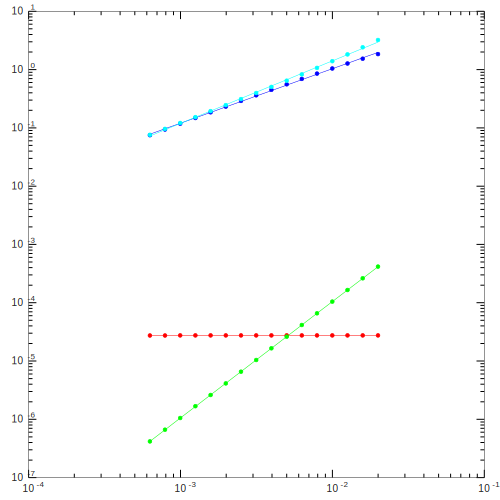

In [93]:
%plot -s 500,500
# Problema modelo.
w0 = [0,1,1,0,0,-1,-1,0];
G = 1;
M1 = 4/G;
M2 = 4/G;
tf = 2*pi;
Tol = 1e-9;
MaxIter = 100;
    
theta = [-1,0,0.5,1];
method = [{"adams\t"},{"euler explicit"},{"crank-nicholson"},{"euler implicit"}];
format1 = [{"r."},{"b."},{"g."},{"c."}];
format2 = [{"r"},{"b"},{"g"},{"c"}];
for i=1:size(theta)(2);
    k = 1;
    err = 0;
    h = 0;
    for j=2.5:0.1:4
        N = floor(10^j);
        if (theta(i)==-1)
            [sol,c,t] = solver_adams_integration(w0,N,tf,G,M1,M2);
        else
            [sol,c,t] = solver_theta(w0,N,tf,G,M1,M2,theta(i),0,Tol,MaxIter);
        end
        t = linspace(0,tf,N);
        h(k) = t(2)-t(1);
        err(k) = norm(sol(N,:)-w0);
        k=k+1;
    end
    loglog(h,err,cell2mat(format1(1,i)));
    printf("\n%s\n",cell2mat(method(1,i)));
    [a,b,r2] = linear_regresion(log(h),log(err));
    hold on;
    loglog(h,exp(a*log(h)+b),cell2mat(format2(1,i)));
end

# Costo computacional

Metodo			 Tiempo de cálculo	 Numero de evaluaciones	 Error relativo 
adams			 0.060540		 229			 1.375204e-05 
euler explicit		 0.347839		 999			 3.459435e-01 
crank-nicholson		 1.942976		 4995			 2.071645e-05 
euler implicit		 2.357629		 5994			 4.141186e-01 


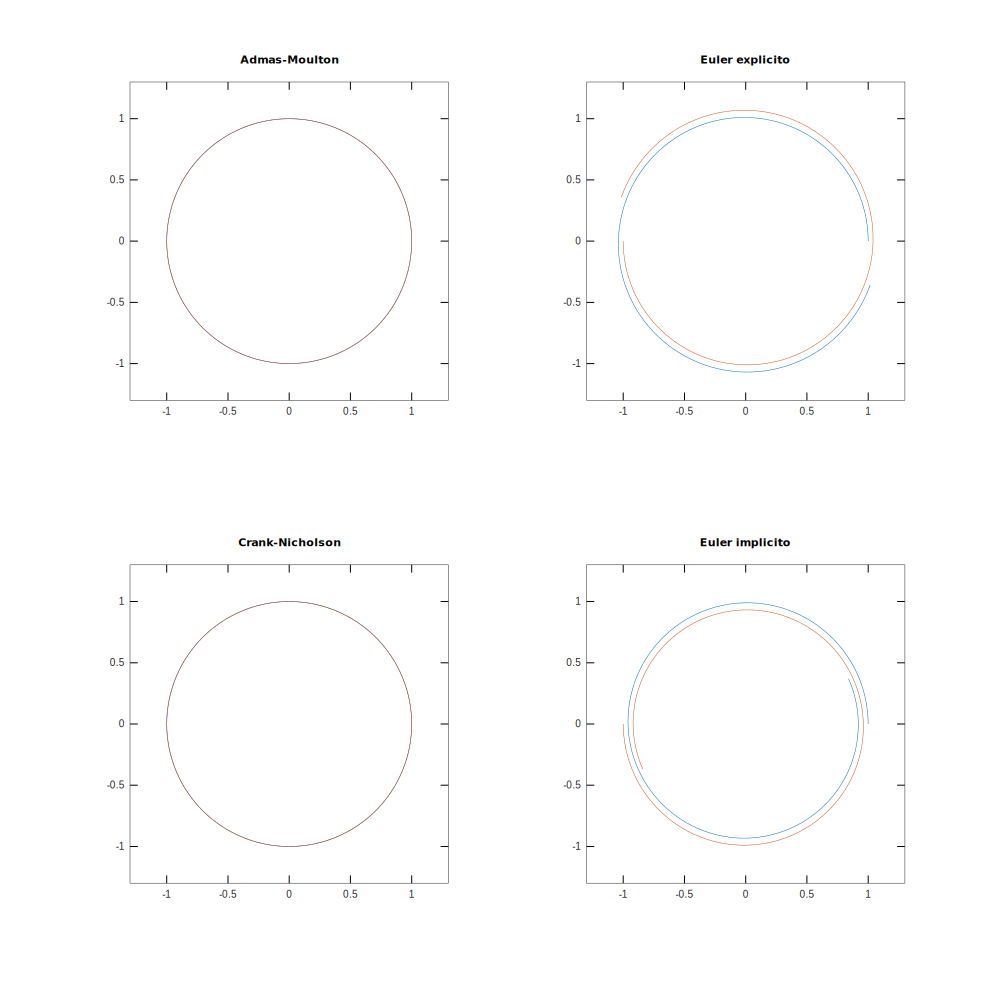

In [94]:
%plot -s 1000,1000
# problema modelo
w0 = [0,1,1,0, 0,-1,-1,0];
G = 1;
M1 = 4/G;
M2 = 4/G;
tf = 2*pi;
N = 1000;
Tol = 1e-9;
MaxIter = 100;

theta = [-1,0,0.5,1];
method = [{"adams\t"},{"euler explicit"},{"crank-nicholson"},{"euler implicit"}];
label = [{"Admas-Moulton"},{"Euler explicito"},{"Crank-Nicholson"},{"Euler implicito"}];
for i=1:size(theta)(2);
    if (theta(i)==-1)
        [sol,c,t] = solver_adams_integration(w0,N,tf,G,M1,M2);
    else
        [sol,c,t] = solver_theta(w0,N,tf,G,M1,M2,theta(i),0,Tol,MaxIter);
    end
    err(i) = norm(sol(N,:)-w0)/norm(w0,2);
    subplot(floor(size(theta)(2)/2),floor(size(theta)(2)/2),i)
    plot(sol(:,2),sol(:,4));
    hold on;
    plot(sol(:,6),sol(:,8));
    axis([-1.3, 1.3, -1.3, 1.3], "square");
    title(cell2mat(label(1,i)))
    tiempo(i) = t;
    calls(i) = c;
end

printf("Metodo\t\t\t Tiempo de cálculo\t Numero de evaluaciones\t Error relativo \n");
for i=1:size(theta)(2)
    printf("%s\t\t %f\t\t %d\t\t\t %e \n",cell2mat(method(1,i)),tiempo(i),calls(i),err(i));
end

# Conservación de energía

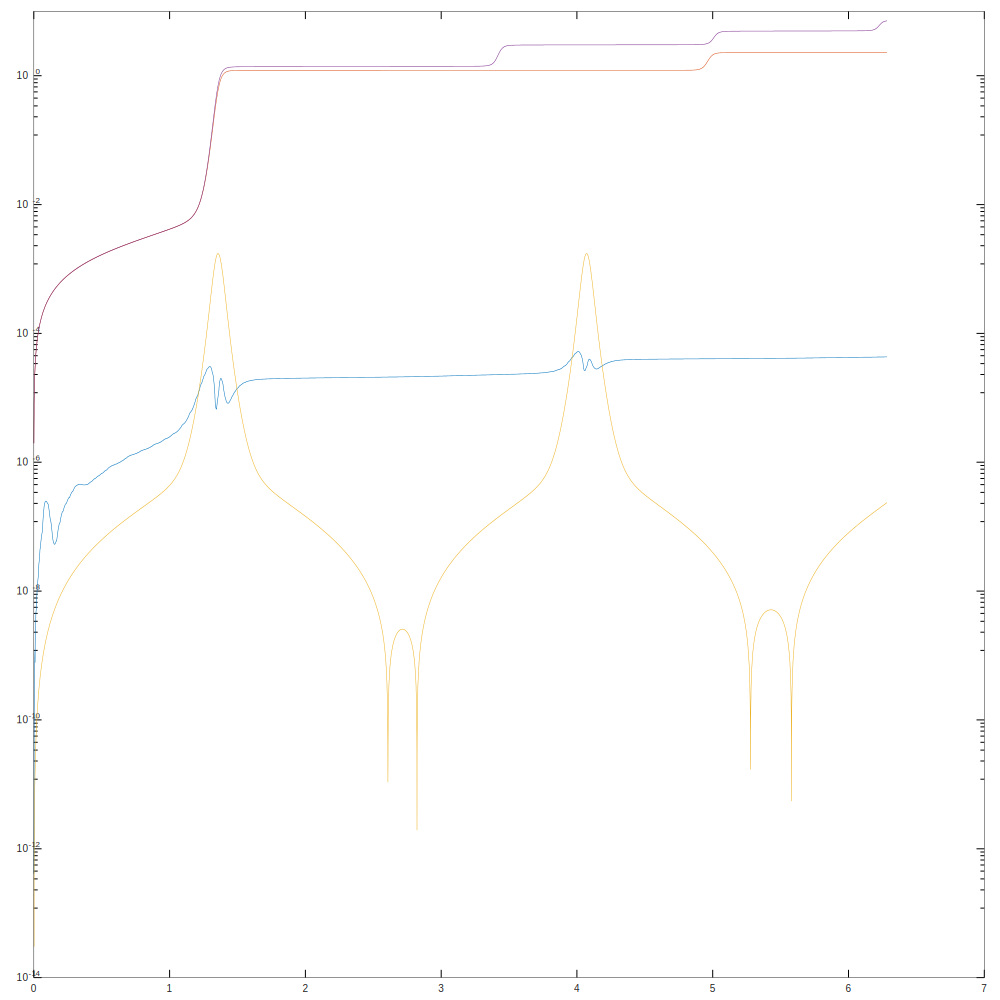

In [95]:
# condiciones del problema
w0 = [0,1,0.5,0, 0,-1,-0.5,0];
G = 1;
M1 = 4/G;
M2 = 4/G;
tf = 2*pi;
N = 10000;
Tol = 1e-9;
MaxIter = 100;

theta = [-1,0,0.5,1];
method = [{"adams\t"},{"euler explicit"},{"crank-nicholson"},{"euler implicit"}];
for i=1:size(theta)(2)
    if (theta(i)==-1)
        [sol,c,t] = solver_adams_integration(w0,N,tf,G,M1,M2);
    else
        [sol,c,t] = solver_theta(w0,N,tf,G,M1,M2,theta(i),0,Tol,MaxIter);
    end
    E = system_energy(sol,G,M1,M2);
    t=linspace(0.0,tf,N);
    n=linspace(0,N,N);
    semilogy(t(2:N),abs(E(2:N)-E(1)));
    hold on;
end